<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# SINGULAR VALUE DECOMPOSITION (SVD)

>## "A singularly valuable decomposition" 
>--Dan Kalman 

>## "Singular Value Decomposition. Love it, learn it."
>--Michael Basial

>## "SVD? Magic, simply magic."
>--John Doherty

### As we've said, the key to representative environmental models is allowing high levels of flexibility through a highly parameterized approach.  But this makes our parameter estimation problem illposed and underdetermined, which means our solution is nonunique even if we overcome problems of increased instability and longer runtimes.  Here we use a "regularized inversion" approach to overcome these problems.  Regularization is anything that makes an intractable problem solvable; for example, using a small number of zones (not highly-parameterized) is a way to regularize an illposed problem.  Regularization as we use here can be grouped into two broad categories: 1) adding soft-knowledge to the problem (Tikhonov regularization) and 2) mathematically reducing the dimensionality of the model (subspace regularization via singular value decomposition (SVD)). In practice we typically use a combination ("hybrid") of these two approaches. 

### It is worth expounding on this difference in regularization approaches. In contrast to Tikhonov regularization, which adds information to the calibration process to achieve numerical stability, subspace methods achieve stability through subtracting parameters, and/or parameter combinations, from the calibration process (making a "subspace" of the full parameter space). Now the calibration process is no longer required to estimate either individual parameters or combinations of correlated parameters that are inestimable given the calibration dataset we have. What combinations are estimable are automatically determined through SVD. 

### The effort needed to take advantage of these regularization strategies is also appreciably different, where SVD is relatively easily brought to bear and becomes "set it and forget it". Moreover, when SVD is used the parameter estimation problem always becomes __unconditionally stable__! Neither of these is true in all cases when adding soft knowledge using Tikhonov regularization. 

### In summary, SVD benefits apply to all models so it is worth widely invoking when using PEST and PEST++.  SVD involves few parameter estimation inputs, default values work for a large range of problems, and it addresses instability for all problems. Can you catch that we can't overemphasize the importance of SVD to parameter estimation?  "Magic" indeed! 


### In this and the next notebooks we'll get under the hood of SVD and see what it does.  A high-level understanding is not needed to take advantage of the power of SVD for your typical calibration parameter estimation problem ("set it and forget it").  BUT in addition to the glow of knowledge that they impart, these SVD concepts will cascade into understanding other tools such as Parameter Identifiability, calculation of uncertainty, and null-space Monte Carlo.  

## Here's another extra mathy expose on SVD: https://gist.github.com/frankcleary/a89da479d85c98f86e31

In [1]:
import os, shutil
import sys
sys.path.append("..")
import pyemu
import pandas as pd
from matplotlib.pyplot import cm 
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets
import flopy as flopy
import numpy as np
noPIL=True
try:
    from PIL import Image
except:
    noPIL=True
%matplotlib inline

## Linear Algebra is the foundation of much of our maths and modeling. At the basis of this is matrices, which are containing vector information like spatial array of properties, mappings from one set of properties to another, the variability of properties.

## Another example of a matrix is just a photograph. It turns out, much of the information contained in a matrix is redundant. If we think of the columns of a matrix as vectors, they are orthogonal but maybe aren't quite the right basis for the infromation. What if we could find another basis, where we rotate to a more suitable set of orthogonal basis vectors and maybe even stretch them?

## Any matrix can be decomposed into 3 matrices
## <center> $\mathbf{M}=\mathbf{U}\mathbf{S}\mathbf{V}^T$ </center>

# Let's evaluate how this works by exploring the information content in an image

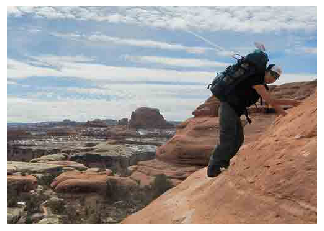

In [2]:
photo = Image.open('clands.jpg')

plt.imshow(photo, interpolation='nearest')
plt.axis('off');

## Convert to grayscale

### By converting to grayscale, what we are left with is a matrix of information where each pixel (e.g. a cell in rows/columns of the matrix) has a value between 0 and 255 indicating intensity. This is then just a matrix with information in it.

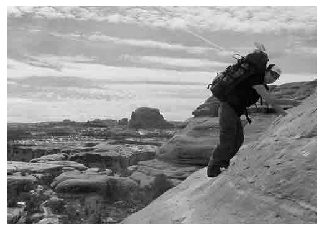

In [3]:
if not noPIL:
    photogray = np.array(photo.convert('L'))
    np.savetxt('clands_gray.dat', photogray, fmt='%d')
else:
    photogray = np.loadtxt('clands_gray.dat', dtype=int)
plt.imshow(photogray, interpolation='nearest', cmap='gray')
plt.axis('off');

## We can treat this like any matrix and perform SVD

In [4]:
U, sigma, V = np.linalg.svd(photogray)
print(photogray.shape)

(351, 500)


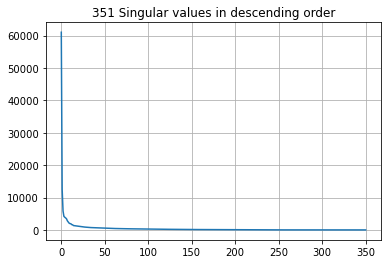

In [5]:
plt.plot(sigma)
plt.grid()
plt.title('{0} Singular values in descending order'.format(len(sigma)));

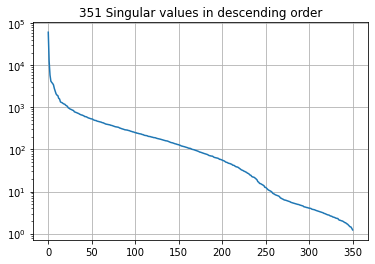

In [6]:
plt.plot(sigma)
plt.grid()
plt.title('{0} Singular values in descending order'.format(len(sigma)));
plt.yscale('log');

## Let's make a little function for using a subset of singular values to reconstitute the image

In [7]:
def recon_image(numsing=1):
    reconimg = np.dot(np.dot(U[:,:numsing], np.diag(sigma[:numsing])),V[:numsing,:])
    basis_vec = np.dot(np.dot(np.atleast_2d(U[:,numsing-1]).T, sigma[numsing-1]),np.atleast_2d(V[numsing-1,:]))
    fig,ax = plt.subplots(ncols=2, figsize=(12,12))
    ax[0].imshow(basis_vec, interpolation='nearest', cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Basis Image')
    ax[1].imshow(reconimg, interpolation='nearest', cmap='gray')
    ax[1].axis('off')
    ss = 's'
    if numsing==1:
        ss = ''
    ax[1].set_title('Reconstruction using {0} singular value{1}'.format(numsing,ss))
    plt.tight_layout()



In [8]:
interact(recon_image, numsing=widgets.widgets.IntSlider(value=1, min=1, max=300, step=1));

interactive(children=(IntSlider(value=1, description='numsing', max=300, min=1), Output()), _dom_classes=('wid…

# Fun times, but what does this have to do with modeling?

### Let's load up a Jacobian Matrix

In [9]:
if os.path.exists(os.path.join('..','master_glm','freyberg_pp.jcb')):
    injac = pyemu.Jco.from_binary(os.path.join('..','master_glm','freyberg_pp.jcb'))
else:
    injac = pyemu.Jco.from_binary('freyberg_pp.jcb')

In [10]:
injac.df().head()

,const_hk6__cn,const_hk7__cn,const_hk8__cn,const_prsity6__cn,const_prsity7__cn,const_prsity8__cn,const_rech10__cn,const_rech11__cn,const_rech12__cn,const_rech13__cn,...,welflux_021,welflux_022,welflux_023,welflux_024,wf0200090016,wf0200110013,wf0200200014,wf0200260010,wf0200290006,wf0200340012
fa_gage_1_20160101,0.000000,0.000000,-11.570395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.388447,2.314079,5.785197,11.801803,13.884474,24.066421
fa_gage_1_20160201,0.000000,0.000000,-13.653066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.851263,2.545487,5.553789,10.413355,12.264618,16.661368
fa_gage_1_20160301,0.000000,0.000000,-15.874581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.828122,2.476064,5.044692,9.186893,10.829889,13.815051
fa_gage_1_20160401,0.000000,0.000000,-17.332451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.619855,2.198375,4.512454,8.469529,9.996821,14.763824
fa_gage_1_20160501,-0.023141,-0.006942,-17.179953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.265801,1.876718,4.271790,8.747218,10.332362,18.778750


In [11]:
if os.path.exists(os.path.join('..','master_glm','freyberg_pp.pst')):
    inpst = pyemu.Pst(os.path.join('..','master_glm','freyberg_pp.pst'))
else:
    inpst = pyemu.Pst('freyberg_pp.pst')

In [12]:
Q = inpst.observation_data.weight.values

In [13]:
Q = np.diag(Q)
Q.shape

(7272, 7272)

In [14]:
X = injac.df().values

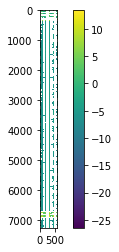

In [15]:
plt.imshow(np.log(np.abs(X)), interpolation='nearest', cmap='viridis')
plt.colorbar()

In [ ]:
X

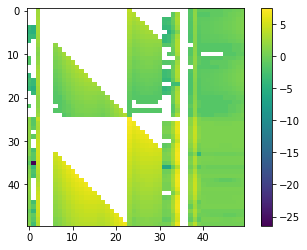

In [16]:
plt.imshow(np.log(np.abs(X[:50,:50])), interpolation='nearest', cmap='viridis')
plt.colorbar()

## We can form up the normal equations matrix (including weights) and take a look at it

This matrix is $\mathbf{X}^T\mathbf{Q}\mathbf{X}$

In [17]:
XtQX=X.T.dot(Q).dot(X)

In [18]:
U, sigma, V = np.linalg.svd(XtQX)

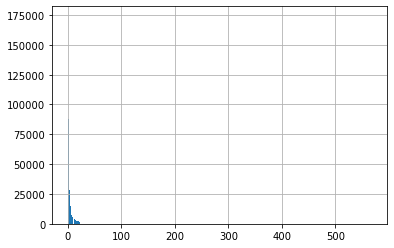

In [19]:
plt.bar(range(len(sigma)),sigma)
plt.grid()

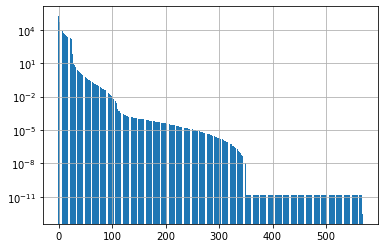

In [20]:
plt.bar(range(len(sigma)),sigma)
plt.yscale('log')
plt.grid()

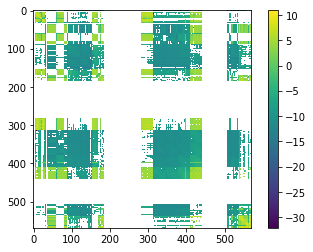

In [21]:
plt.imshow(np.log(XtQX), interpolation='nearest', cmap='viridis')
plt.colorbar()

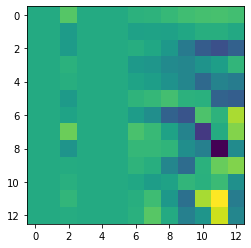

In [22]:
plt.imshow(V[:13,:13])

In [23]:
def SV_bars(SV=1):
    plt.figure(figsize=(13,4))
    plt.bar(list(range(U.shape[0])),U[:,SV-1])
    plt.grid()
    #plt.yscale('log')
    plt.xlim([0,75])
    plt.ylim([-1,1])
    plt.xticks(list(range(75)))
    plt.title('Singular vector showing parameter contributions to singular vector #{0}'.format(SV))
    #print(U.shape)
    plt.gca().set_xticklabels(inpst.parameter_data['parnme'][:75], rotation=90);

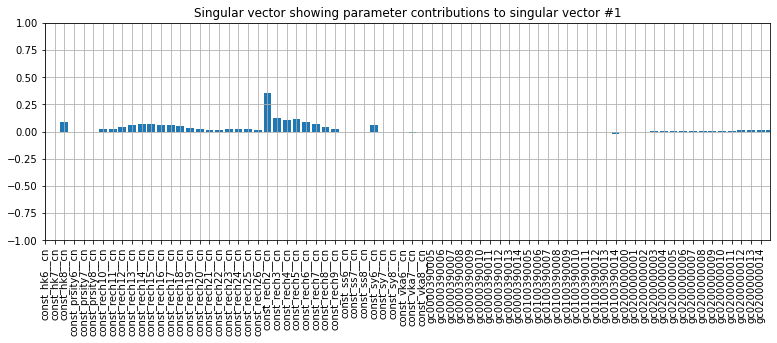

In [24]:
SV_bars(1)

In [25]:
interact(SV_bars, SV=widgets.widgets.IntSlider(value=1, min=1, max=20, step=1));

interactive(children=(IntSlider(value=1, description='SV', max=20, min=1), Output()), _dom_classes=('widget-in…

### Great - finally how does this impact our calibration of a K-field?

In [26]:
ls freyberg_truth/

Invalid switch - "".


In [27]:
m = flopy.modflow.Modflow.load('freyberg.truth.nam',model_ws='freyberg_truth',load_only=["upw", "bas6"],check=False)

In [28]:
v = pyemu.geostats.ExpVario(1.0,a=200,anisotropy=1.0,bearing=45)
struct = pyemu.geostats.GeoStruct(variograms=v)

In [29]:
bd = pyemu.helpers.kl_setup(num_eig=800,sr=m.sr,struct=struct,prefixes='hk',basis_file="basis.jco")

In [30]:
basis = pyemu.Matrix.from_binary("basis.jco").to_dataframe()

In [31]:
basis

,eig_0000,eig_0001,eig_0002,eig_0003,eig_0004,eig_0005,eig_0006,eig_0007,eig_0008,eig_0009,...,eig_0790,eig_0791,eig_0792,eig_0793,eig_0794,eig_0795,eig_0796,eig_0797,eig_0798,eig_0799
i0000j0000,-0.001602,-0.003171,0.004677,-0.003088,0.006116,-0.006093,0.009025,-0.007399,0.011767,-0.004367,...,-0.002026,0.005435,-0.003407,0.004111,-0.002757,0.002757,-0.001384,0.002086,-0.001399,0.000702
i0000j0001,-0.002598,-0.005149,0.007609,-0.004817,0.009551,-0.009940,0.014124,-0.012109,0.018464,-0.006365,...,0.003803,-0.010847,0.007047,-0.008192,0.005690,-0.005488,0.002752,-0.004298,0.002880,-0.001444
i0000j0002,-0.003555,-0.007050,0.010427,-0.006184,0.012269,-0.013636,0.018157,-0.016634,0.023765,-0.007251,...,-0.004800,0.015235,-0.010497,0.011499,-0.008470,0.007701,-0.003861,0.006394,-0.004283,0.002147
i0000j0003,-0.004444,-0.008814,0.013043,-0.007057,0.014003,-0.017067,0.020735,-0.020834,0.027156,-0.006831,...,0.004834,-0.018247,0.013705,-0.013768,0.011054,-0.009218,0.004621,-0.008343,0.005587,-0.002801
i0000j0004,-0.005243,-0.010402,0.015396,-0.007358,0.014604,-0.020154,0.021632,-0.024613,0.028344,-0.005173,...,-0.003899,0.019614,-0.016600,0.014797,-0.013386,0.009906,-0.004965,0.010102,-0.006764,0.003391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i0039j0015,-0.005243,0.010402,0.015396,0.007358,0.014604,0.020154,-0.021632,-0.024613,0.028344,-0.005173,...,-0.003899,0.019614,-0.016600,-0.014797,0.013386,0.009906,0.004965,0.010102,0.006764,0.003391
i0039j0016,-0.004444,0.008814,0.013043,0.007057,0.014003,0.017067,-0.020735,-0.020834,0.027156,-0.006831,...,0.004834,-0.018247,0.013705,0.013768,-0.011054,-0.009218,-0.004621,-0.008343,-0.005587,-0.002801
i0039j0017,-0.003555,0.007050,0.010427,0.006184,0.012269,0.013636,-0.018157,-0.016634,0.023765,-0.007251,...,-0.004800,0.015235,-0.010497,-0.011499,0.008470,0.007701,0.003861,0.006394,0.004283,0.002147
i0039j0018,-0.002598,0.005149,0.007609,0.004817,0.009551,0.009940,-0.014124,-0.012109,0.018464,-0.006365,...,0.003803,-0.010847,0.007047,0.008192,-0.005690,-0.005488,-0.002752,-0.004298,-0.002880,-0.001444


In [32]:
i = basis.index.map(lambda x: int(x[1:5]))
j = basis.index.map(lambda x: int(x[-4:]))

## Let's check out a continuous K field

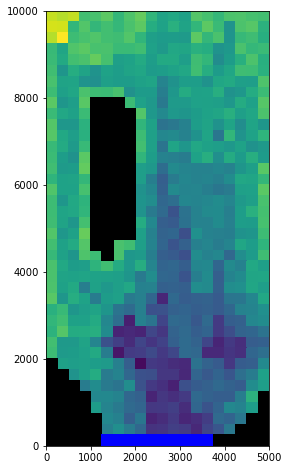

In [33]:
arr = np.loadtxt(os.path.join("freyberg_truth","hk.truth.ref"))
plt.figure(figsize=(4,8))
mm = flopy.plot.PlotMapView(model=m, ax=plt.gca())
mm.plot_array(arr)
hk_true = arr.copy()
mm.plot_ibound();

## We can reconstruct it

In [34]:
basis_arr = np.array(basis.values)
flat_arr = np.atleast_2d(arr.flatten()).transpose()

In [35]:
basis_arr.shape

(800, 800)

In [36]:
flat_arr.shape

(800, 1)

In [37]:
def plot_enchilada(eig):
    fig,ax = plt.subplots(ncols=3, figsize=(14,8))
    arr = np.zeros((m.nrow,m.ncol))
    arr[i,j] = basis.iloc[:,eig]
    mm = flopy.plot.PlotMapView(model=m, ax=ax[0])
    mm.plot_array(arr)
    mm.plot_ibound()
    #mm = plt.imshow(arr)
    ax[0].set_title('Plot of individual SV\nnative scale')
    basis_eig = basis_arr[:,:eig+1].transpose()
    factors = np.dot(basis_eig,flat_arr).transpose()
    factors = np.dot(factors,basis_eig).reshape(arr.shape)
    mm2 = flopy.plot.PlotMapView(model=m, ax=ax[1])
    mm2.plot_array(factors, vmin=0,vmax=np.max(hk_true))
    mm2.plot_ibound()
    ax[1].set_title('Reconstructed field\nTrue Scale')
    ax[2].set_title('True Field')    
    mm3 = flopy.plot.PlotMapView(model=m, ax=ax[2])
    c = mm3.plot_array(hk_true,vmin=0,vmax=np.max(hk_true))
    mm3.plot_ibound()
    plt.suptitle('Using {0} SVs'.format(eig+1))
    plt.colorbar(c)

In [38]:
interact(plot_enchilada, eig=widgets.IntSlider(description="eig comp:", 
                                           continuous_update=True, max=799));

interactive(children=(IntSlider(value=0, description='eig comp:', max=799), Output()), _dom_classes=('widget-i…